Nota: Las gráficas que se pueden ver aquí están construidas con 0.5 años terrestres, después de 30m de procesamiento, con un paso de $10^{-8}$. En otras palabras, la pendiente obtenida (51.61, visible al final) es tan sólo una aproximación hecha con 2 puntos. De ahí que, si se fuera a realizar la simulación con más años terrestres (2.5 para obtener 10 puntos), se mejoraría el resultado. No obstante, no contamos ni con la capacidad de procesamiento ni de memoria para realizar esta simulación hasta 2.5 años terrestres en un tiempo razonable. Si se quiere repetir la simulación aumentando la cantidad de años terrestres calculados, basta con cambiar la variable tmax ubicada en el cuarto bloque de código por el valor deseado (actualmente está en 0.5) y correr el programa. Para obtener 10 puntos, sería necesario correr el programa cambiando este valor por 2.5.

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm 

In [2]:
class Planeta:
    
    def __init__(self, e, a, t):
        
        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo
        
        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor
        self.alpha = 1.1e-8
        
        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(2)
        self.v = np.zeros_like(self.r)
        
        self.r[0] = self.a_*(1+self.e)
        self.v[1] = np.sqrt( self.G*(1-self.e)/(self.a_*(1.+self.e)) )
        
        d = np.linalg.norm(self.r)
        self.a = (-self.G/d**3)*self.r*(1+self.alpha/np.square(d))
        
        self.R = np.zeros((len(t),len(self.r)))
        self.V = np.zeros_like(self.R)
        
        # El valor del pasado
        self.rp = self.r
        
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.GetAceleration()
        
        if i==0:
            self.v += self.dt*self.a
            self.r = self.rp + self.v*self.dt
        
        else:
            
            # rp pasado, r presente, rf futuro
            self.rf = self.r + self.v*self.dt + 0.5*self.a*self.dt**2
            
            d = np.linalg.norm(self.rf)
            self.af = (-self.G/d**3)*self.rf*(1+self.alpha/np.square(d))
            
            self.v = self.v + (self.dt/2)*(self.af+self.a)
            
            self.rp = self.r
            self.r = self.rf
            self.a = self.af
            
    
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
        
    
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetAceleration(self):
        
        d = np.linalg.norm(self.r)
        self.a = (-self.G/d**3)*self.r*(1+self.alpha/np.square(d))
    
    def GetPerihelio(self):
        
        Dist = np.linalg.norm(self.R,axis=1)
        
        time = np.zeros(10)
        x = np.zeros(10)
        y = np.zeros(10)
        it = np.zeros(10)
        
        count = 0
        
        for i in range(1,len(self.R)-1):
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                time[count] = self.t[i]
                x[count] = self.R[i,0]
                y[count] = self.R[i,1]
                it[count] = i
                count += 1
                
            
        return [time, x, y, it]

In [3]:
def GetPlanetas(t):
    
    Mercurio = Planeta(0.205630,0.387098,t)
    
    
    return [Mercurio]

In [4]:
dt = 1e-8
tmax = 0.5
t = np.arange(0.,tmax,dt)
Planetas = GetPlanetas(t)

In [5]:
def RunSimulation(t,Planetas):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        #print(it)
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)
            # Aca debes agregar la interaccion con la pared
            
            
    return Planetas

In [6]:
Planetas = RunSimulation(t,Planetas)

Running simulation: 100%|██████████| 50000000/50000000 [24:53<00:00, 33469.40 Steps/s]


In [7]:
Datos = Planetas[0].GetPerihelio()

In [8]:
#Tiempos en que llega al perihelio
Datos[0]

array([0.12042076, 0.36126229, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [9]:
#Posición en X en cada perihelio
Datos[1]

array([-0.307499, -0.307499,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ])

In [10]:
#Posición en Y en cada perihelio
Datos[2]

array([-3.05201854e-08, -2.15849268e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [11]:
Datos[3]

array([12042076., 36126229.,        0.,        0.,        0.,        0.,
              0.,        0.,        0.,        0.])

In [12]:
Planetas[0].GetPosition()[120421]

array([0.46656554, 0.00987041])

In [36]:
xpos = Planetas[0].GetPosition()[:,0]
rango = 12042076
x = np.zeros(rango)
for i in range(rango):
    x[i] = xpos[i]
    
ypos = Planetas[0].GetPosition()[:,1]
y = np.zeros(rango)
for i in range(rango):
    y[i] = ypos[i]

<IPython.core.display.Javascript object>


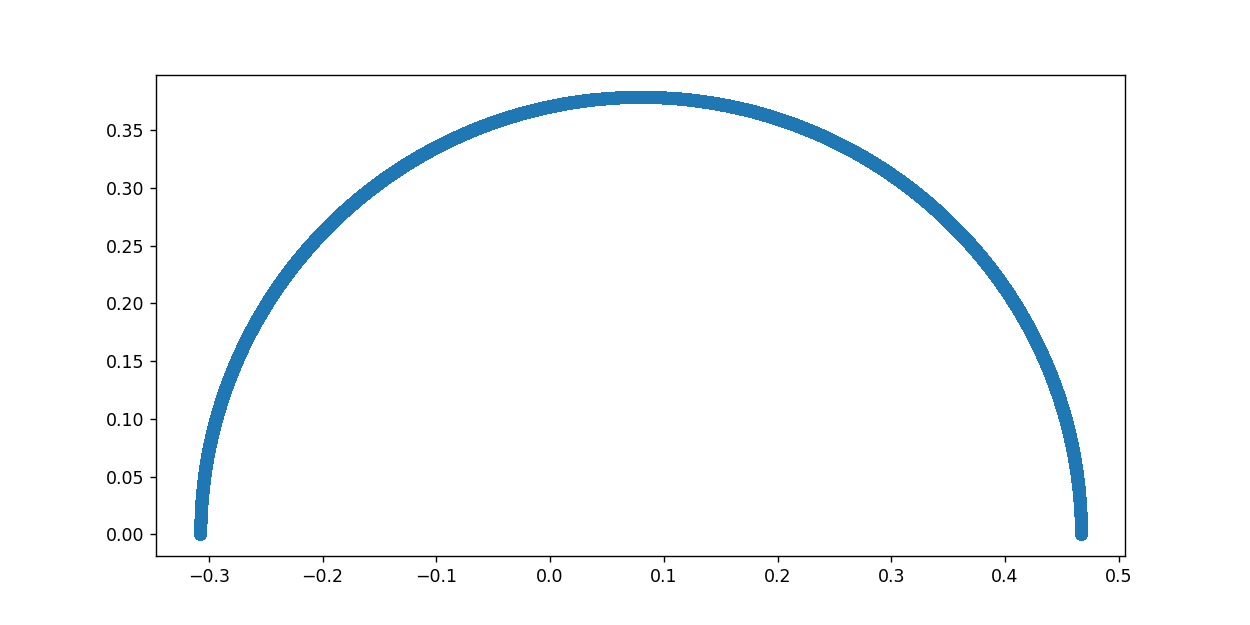

In [41]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.scatter(x, y)

In [43]:
#Tiempos = Datos[0]
Tiempos = Datos[0][Datos[0] != 0.]
#X = Datos[1]
X = Datos[1][Datos[1] != 0.]
#Y = Datos[2]
Y = Datos[2][Datos[2] != 0.]
Angulos = np.zeros(len(X))

for i in range(len(Angulos)):
    Angulos[i] = np.arctan(Y[i]/X[i])+np.pi

"""
deltaAngulos = np.zeros(len(Angulos))

deltaAngulos[0] = 0.

for i in range(1, len(deltaAngulos)):
    deltaAngulos[i] = np.abs(Angulos[i]-Angulos[i-1]) + deltaAngulos[i-1]

Tiempos
"""
Tiempos

array([0.12042076, 0.36126229])

In [44]:
Angulos*(180/np.pi)

array([180.00000569, 180.00004022])

In [45]:
#implementamos minimos cuadrados

Angulos = Angulos*(180/np.pi)
#deltaAngulos = deltaAngulos*(180/np.pi)

n = len(Tiempos)

m = (n * np.sum(Tiempos * Angulos) - np.sum(Tiempos) * np.sum(Angulos)) / (n * np.sum(Tiempos**2) - (np.sum(Tiempos))**2)

m_segundos = m * (3600/1) * (100/1)

"""
m = (n * np.sum(Tiempos * deltaAngulos) - np.sum(Tiempos) * np.sum(deltaAngulos)) / (n * np.sum(Tiempos**2) - (np.sum(Tiempos))**2)

regresion = m * Tiempos
"""

m_segundos

51.61710318745525

<IPython.core.display.Javascript object>


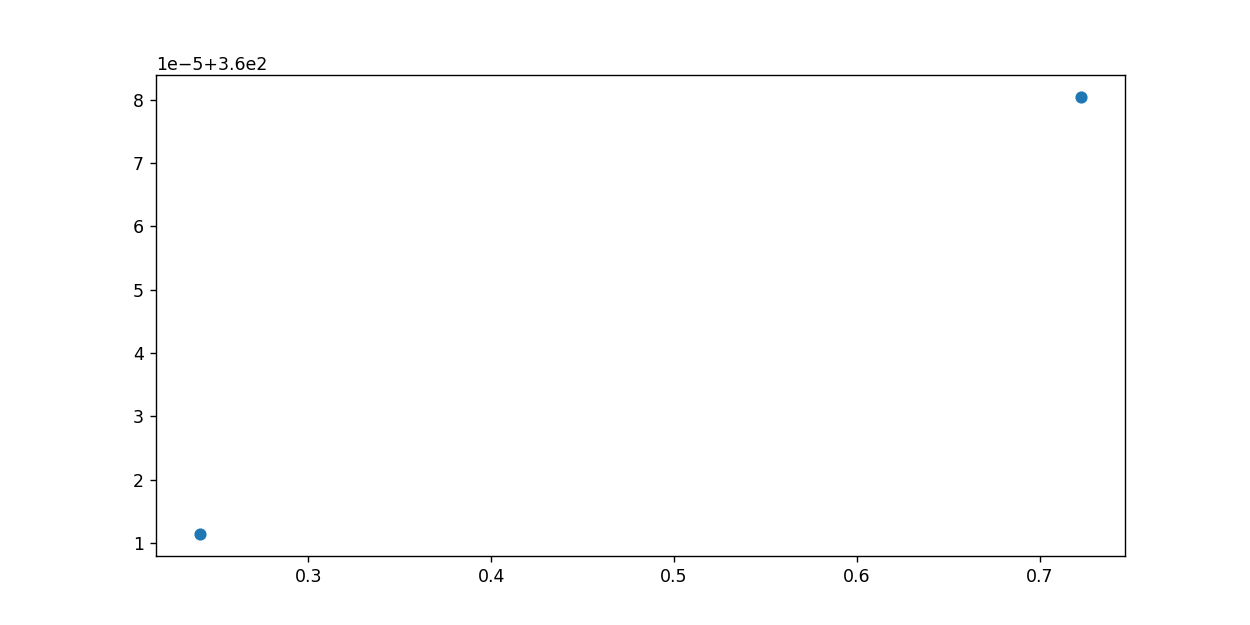

In [46]:
fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(111)
ax2.scatter(Tiempos*2,Angulos*2)
#plt.plot(Tiempos,regresion)

In [47]:
A = np.vstack([Tiempos, np.ones(len(Tiempos))]).T

In [48]:
m, c = np.linalg.lstsq(A, Angulos, rcond=None)[0]

In [49]:
m*(3600/1)*(100/1)

51.61710328188995